# EL4106 Proyect 1 - Style transfer with VGG16 CNN

## Preliminary configurations

### Downloading the data

In [1]:
# Run this cell using the styletransfer22.2 account
from google.colab import drive, output
drive.mount("/content/drive")

!rm -rf /content/sample_data
!cp /content/drive/MyDrive/test2017.zip /content/
!unzip -qo /content/test2017.zip -d /content/
!rm /content/test2017.zip
!mkdir /content/img
!mkdir /content/data/test2017/features

output.clear()
!echo "Done!"

Done!


### Creating data structures

In [1]:
import os
import numpy as np
import torch
import torchvision
from torch import nn
from torchvision import models
from torchvision import io
import matplotlib.pyplot as plt
from PIL import Image
import time
from tqdm import tqdm

TO_TENSOR = torchvision.transforms.ToTensor()


class UnsupervisedImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, image_names, transform=None, use_gpu=False, size_limit=None):
        self.img_dir = img_dir
        self.image_names = image_names[:size_limit]
        self.transform = transform
        self.use_gpu = use_gpu

    @classmethod
    def from_dir(cls, img_dir, *args, **kwargs):
        files = np.array([f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))])
        return cls(img_dir, files, *args, **kwargs)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.img_dir, self.image_names[idx])).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image


class VGG16DecoderImageDataset(UnsupervisedImageDataset):
    def __init__(self, *args, encoder, **kwargs):
        super().__init__(*args, **kwargs)
        self.encoder = encoder

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.img_dir, self.image_names[idx])).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)

        if self.use_gpu:
            image = image.to("cuda")
        features = self.encoder(image)
        return features, image

    def split(self, train_size):
        total_size = len(self.image_names)
        train_idx = np.random.default_rng().choice(total_size, int(total_size * train_size), replace=False)
        test_idx = np.delete(np.arange(total_size), train_idx)

        train_ds = VGG16DecoderImageDataset(
            self.img_dir,
            self.image_names[train_idx],
            self.transform,
            self.use_gpu,
            encoder=self.encoder,
        )
        test_ds = VGG16DecoderImageDataset(
            self.img_dir,
            self.image_names[test_idx],
            self.transform,
            self.use_gpu,
            encoder=self.encoder,
        )
        return train_idx, test_idx, train_ds, test_ds


class VGG16DecoderImageDataloader:
    def __init__(self, dataset, batch_size, use_gpu=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.use_gpu = use_gpu

    def __len__(self):
        return int(np.ceil(len(self.dataset) / self.batch_size))

    def __iter__(self):
        self.indices = list(range(len(self.dataset)))
        np.random.default_rng().shuffle(self.indices)
        return self

    def __next__(self):
        if not self.indices:
            raise StopIteration
        indices = self.indices[:self.batch_size]
        self.indices = self.indices[self.batch_size:]
        result_feats = torch.zeros((self.batch_size, 512, 14, 14))
        result_image = torch.zeros((self.batch_size, 3, 224, 224))
        for i, idx in enumerate(indices):
            features, image = self.dataset[idx]
            result_feats[i] = features
            result_image[i] = image
        if self.use_gpu:
            result_feats = result_feats.cuda()
            result_image = result_image.cuda()
        return result_feats, result_image


## Model definition

### Encoder

We import the VGG16 network available in Pytorch, using the default pretrained weights. Since VGG16 contains three parts (features, average pooling and MLP), we only extract the one we care about: the features, corresponding to the convolutional layers.

Choosing the depth is also implemented, cutting off each level by the max pooling layers. This depth is specified upon instancing the `VGG16Encoder` class.

In [2]:
class VGG16Encoder(nn.Module):
    def __init__(self, depth=5, use_gpu=False):
        super().__init__()
        all_layers = (
            models
            .vgg16(weights=models.VGG16_Weights.DEFAULT)
            .eval()
            .features
        )[:26]
        if use_gpu:
            all_layers = all_layers.to("cuda")

        # Hardcoded indices for each depth
        indices = {
            1: 4,
            2: 9,
            3: 16,
            4: 23,
            5: 26,
        }
        self.model = all_layers[:indices[depth] + 1]

    def forward(self, x):
        return self.model(x)

In [3]:
# This code is to see the layers in the VGG16 encoder
encoder_test = VGG16Encoder()
encoder_test.model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

### Decoder

The decoder is created by mirroring the VGG16 convolutional layers, replacing the max pooling layers with upsampling ones.

In [4]:
class VGG16Decoder(nn.Module):
    def __init__(self, depth=5, use_gpu=False):
        super().__init__()
        all_layers = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            # nn.ReLU(inplace=True),
        )
        if use_gpu:
            all_layers = all_layers.to("cuda")

        # Hardcoded indices for each depth
        indices = {
            1: 1,
            2: 8,
            3: 15,
            4: 20,
            5: 25,
        }
        self.model = all_layers[:indices[depth] + 1]

    def forward(self, x):
        return self.model(x)

In [5]:
decoder_test = VGG16Decoder()
decoder_test.model

Sequential(
  (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
  (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
  (17): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU(inplace=

### Loss function

In [6]:
class VGG16DecoderLossFunction(nn.Module):
    def __init__(self, weight=1, show_progress=False, show_images=False, use_gpu=False):
        super().__init__()
        self.weight = weight
        self.show_progress = show_progress
        self.show_images = show_images
        self.use_gpu = use_gpu

    def forward(self, recon_image, input_image, encoder):
        if self.use_gpu:
            encoder = encoder.cuda()
            input_image = input_image.cuda()
            recon_image = recon_image.cuda()

        input_features = encoder(input_image)
        recon_features = encoder(recon_image)

        image_loss = torch.pow(torch.linalg.norm(input_image - recon_image), 2)
        feature_loss = torch.pow(torch.linalg.norm(input_features - recon_features), 2)
        total_loss = image_loss + self.weight * feature_loss

        if self.show_progress:
            if self.show_images:
                for i in range(input_image.detach().shape[0]):
                    fig, ax = plt.subplots(1, 2)
                    ax[0].imshow(input_image.detach()[i].permute(1, 2, 0).cpu().numpy())
                    ax[1].imshow(recon_image.detach()[i].permute(1, 2, 0).cpu().numpy() / torch.max(recon_image.detach().cpu()))

                    ax[0].set_title("Input image")
                    ax[1].set_title("Reconstructed image")
            print(f"""
                \rLoss = {total_loss}
                \r=========================
                \rInput                  -> {input_image.shape}
                \rInput min              -> {torch.min(input_image)}
                \rInput max              -> {torch.max(input_image)}
                \rReconstructed          -> {recon_image.shape}
                \rReconstructed min      -> {torch.min(recon_image)}
                \rReconstructed max      -> {torch.max(recon_image)}
                \rInput features         -> {input_features.shape}
                \rReconstructed features -> {recon_features.shape}
            """
            )
            plt.show()
        return total_loss

### Whitening and Coloring Transforms

In [7]:
#TODO: refactor variable names
def wct(alpha, cf, sf, s1f=None, beta=None):
    # content image whitening
    cf = cf.double()
    c_channels, c_width, c_height = cf.size(0), cf.size(1), cf.size(2)
    cfv = cf.view(c_channels, -1)  # c x (h x w)

    c_mean = torch.mean(cfv, 1)  # perform mean for each row
    # add dim and replicate mean on rows
    c_mean = c_mean.unsqueeze(1).expand_as(cfv)
    cfv = cfv - c_mean  # subtract mean element-wise

    c_covm = torch.mm(cfv, cfv.t()).div(
        (c_width * c_height) - 1)  # construct covariance matrix
    # singular value decomposition
    c_u, c_e, c_v = torch.svd(c_covm, some=False)

    k_c = c_channels
    for i in range(c_channels):
        if c_e[i] < 0.00001:
            k_c = i
            break
    c_d = (c_e[0:k_c]).pow(-0.5)

    w_step1 = torch.mm(c_v[:, 0:k_c], torch.diag(c_d))
    w_step2 = torch.mm(w_step1, (c_v[:, 0:k_c].t()))
    whitened = torch.mm(w_step2, cfv)

    # style image coloring
    sf = sf.double()
    _, s_width, s_heigth = sf.size(0), sf.size(1), sf.size(2)
    sfv = sf.view(c_channels, -1)

    s_mean = torch.mean(sfv, 1)
    s_mean = s_mean.unsqueeze(1).expand_as(sfv)
    sfv = sfv - s_mean

    s_covm = torch.mm(sfv, sfv.t()).div((s_width * s_heigth) - 1)
    s_u, s_e, s_v = torch.svd(s_covm, some=False)

    s_k = c_channels  # same number of channels ad content features
    for i in range(c_channels):
        if s_e[i] < 0.00001:
            s_k = i
            break
    s_d = (s_e[0:s_k]).pow(0.5)

    c_step1 = torch.mm(s_v[:, 0:s_k], torch.diag(s_d))
    c_step2 = torch.mm(c_step1, s_v[:, 0:s_k].t())
    colored = torch.mm(c_step2, whitened)

    cs0_features = colored + s_mean.resize_as_(colored)
    cs0_features = cs0_features.view_as(cf)

    # additional style coloring
    if beta:
        sf = s1f
        sf = sf.double()
        _, s_width, s_heigth = sf.size(0), sf.size(1), sf.size(2)
        sfv = sf.view(c_channels, -1)

        s_mean = torch.mean(sfv, 1)
        s_mean = s_mean.unsqueeze(1).expand_as(sfv)
        sfv = sfv - s_mean

        s_covm = torch.mm(sfv, sfv.t()).div((s_width * s_heigth) - 1)
        s_u, s_e, s_v = torch.svd(s_covm, some=False)

        s_k = c_channels
        for i in range(c_channels):
            if s_e[i] < 0.00001:
                s_k = i
                break
        s_d = (s_e[0:s_k]).pow(0.5)

        c_step1 = torch.mm(s_v[:, 0:s_k], torch.diag(s_d))
        c_step2 = torch.mm(c_step1, s_v[:, 0:s_k].t())
        colored = torch.mm(c_step2, whitened)

        cs1_features = colored + s_mean.resize_as_(colored)
        cs1_features = cs1_features.view_as(cf)

        target_features = beta * cs0_features + (1.0 - beta) * cs1_features
    else:
        target_features = cs0_features

    ccsf = alpha * target_features + (1.0 - alpha) * cf
    return ccsf.float().unsqueeze(0)


def wct_mask(cf, sf):
    cf = cf.double()
    cf_sizes = cf.size()
    c_mean = torch.mean(cf, 1)
    c_mean = c_mean.unsqueeze(1).expand_as(cf)
    cf -= c_mean

    c_covm = torch.mm(cf, cf.t()).div(cf_sizes[1] - 1)
    c_u, c_e, c_v = torch.svd(c_covm, some=False)

    k_c = cf_sizes[0]
    for i in range(cf_sizes[0]):
        if c_e[i] < 0.00001:
            k_c = i
            break
    c_d = (c_e[0:k_c]).pow(-0.5)
    whitened = torch.mm(
        torch.mm(torch.mm(c_v[:, 0:k_c], torch.diag(c_d)), (c_v[:, 0:k_c].t())), cf)

    sf = sf.double()
    sf_sizes = sf.size()
    sfv = sf.view(sf_sizes[0], sf_sizes[1] * sf_sizes[2])
    s_mean = torch.mean(sfv, 1)
    s_mean = s_mean.unsqueeze(1).expand_as(sfv)
    sfv -= s_mean

    s_covm = torch.mm(sfv, sfv.t()).div((sf_sizes[1] * sf_sizes[2]) - 1)
    s_u, s_e, s_v = torch.svd(s_covm, some=False)

    s_k = sf_sizes[0]
    for i in range(sf_sizes[0]):
        if s_e[i] < 0.00001:
            s_k = i
            break
    s_d = (s_e[0:s_k]).pow(0.5)
    ccsf = torch.mm(torch.mm(
        torch.mm(s_v[:, 0:s_k], torch.diag(s_d)), s_v[:, 0:s_k].t()), whitened)

    ccsf += s_mean.resize_as_(ccsf)
    return ccsf.float()


## Decoder training

### Training functions

In [8]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu, encoder):
    y_predicted = model(x_batch)
    if use_gpu:
        y_predicted = y_predicted.cuda()
    loss = criterion(y_predicted, y_batch, encoder)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss


def evaluate(val_loader, model, encoder, criterion, use_gpu):
    cumulative_loss = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        loss = criterion(y_predicted, y_val, encoder)

        cumulative_loss += loss.item()

    return cumulative_loss / len(val_loader)


def train_model(model, train_dataset, val_dataset, epochs, criterion,
                batch_size, lr, encoder, n_evaluations_per_epoch=6,
                use_gpu=False, loader_kwargs=None):
    if use_gpu:
        model = model.cuda()
        encoder = encoder.cuda()
        criterion = criterion.cuda()
    if loader_kwargs is None:
        loader_kwargs = {}

    # Dataloaders
    train_loader = VGG16DecoderImageDataloader(
        train_dataset, batch_size=batch_size, use_gpu=use_gpu, **loader_kwargs,
    )
    val_loader = VGG16DecoderImageDataloader(
        val_dataset, batch_size=batch_size, use_gpu=use_gpu, **loader_kwargs,
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    curves = {
        "train_loss": [],
        "val_loss": [],
    }

    initial_time = time.perf_counter()
    n_batches = len(train_loader)

    # Initialize the values to display them
    train_loss = None
    val_loss = None

    for epoch in range(epochs):
        # Metrics
        cumulative_train_loss = 0
        train_loss_count = 0

        # Train the model
        model.train()
        progress_bar = tqdm(
            enumerate(train_loader),
            total=n_batches,
            desc=f"EPOCH {epoch + 1}/{epochs} | Training the decoder (train loss = {train_loss}, validation loss = {val_loss})",
        )
        for i, (x_batch, y_batch) in progress_bar:
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(
                x_batch, y_batch, model, optimizer, criterion, use_gpu, encoder,
            )
            cumulative_train_loss += loss.item()
            train_loss_count += 1

            train_loss = cumulative_train_loss / train_loss_count
            progress_bar.desc = f"EPOCH {epoch + 1}/{epochs} | Training the decoder (train loss = {train_loss}, validation loss = {val_loss})"

        train_loss = cumulative_train_loss / train_loss_count

        # Run the evaluation
        del x_batch, y_batch
        torch.cuda.empty_cache()
        val_loss = evaluate(val_loader, model, encoder, criterion, use_gpu)

        # Save the curves
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

    model = model.cpu()
    return curves


def show_curves(curves):
    fig, ax = plt.subplots(1, 1, figsize=(13, 5))
    fig.set_facecolor("white")

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax.plot(epochs, curves["val_loss"], label="validation")
    ax.plot(epochs, curves["train_loss"], label="training")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Loss evolution during training")
    ax.legend()

    plt.show()

### Training parameters
Having defined all the code to train the network, we have to run it. We start off by creating a dataset from the images from COCO (specifically, the 2017 test dataset).

In [9]:
LEARNING_RATE = 5e-4
BATCH_SIZE = 10
EPOCHS = 1
USE_GPU = True
NORM_MEAN = (0.485, 0.456, 0.406)
NORM_STD = (0.229, 0.224, 0.225)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.Normalize(NORM_MEAN, NORM_STD),
])

vgg_encoder = VGG16Encoder(use_gpu=USE_GPU)

untransformed_ds = VGG16DecoderImageDataset.from_dir(
    "data/test2017",
    encoder=vgg_encoder,
    transform=torchvision.transforms.ToTensor(),
    use_gpu=USE_GPU,
)
transformed_ds = VGG16DecoderImageDataset.from_dir(
    "data/test2017",
    encoder=vgg_encoder,
    transform=transform,
    use_gpu=USE_GPU,
)
reduced_ds = VGG16DecoderImageDataset.from_dir(
    "data/test2017",
    encoder=vgg_encoder,
    transform=transform,
    use_gpu=USE_GPU,
    size_limit=1000,
)

# Loss function and model to train
criterion = VGG16DecoderLossFunction(1, use_gpu=USE_GPU)
vgg_decoder = VGG16Decoder(use_gpu=USE_GPU)

### Training execution

In [10]:
# Flush the memory in cuda before running
torch.cuda.empty_cache()

_, _, train_ds, val_ds = reduced_ds.split(0.7)

# Run the training
curves = train_model(
    vgg_decoder,
    train_ds,
    val_ds,
    EPOCHS,
    criterion,
    BATCH_SIZE,
    LEARNING_RATE,
    vgg_encoder,
    use_gpu=USE_GPU,
)

show_curves(curves)

EPOCH 1/1 | Training the decoder (train loss = None, validation loss = None):   0%|          | 0/70 [00:07<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 62.00 MiB (GPU 0; 2.00 GiB total capacity; 1.71 GiB already allocated; 0 bytes free; 1.74 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Evaluating the model

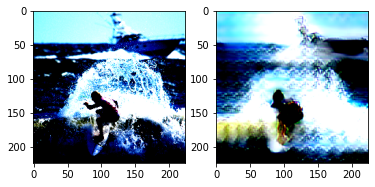

In [ ]:
INDEX = 51

feats = vgg_encoder(val_ds[INDEX][1])
img_tensor = torch.zeros((1, *feats.shape))
img_tensor[0] = feats

fig, ax = plt.subplots(1, 2)
ax[0].imshow(val_ds[INDEX][1].permute(1, 2, 0).cpu())
ax[1].imshow(vgg_decoder.cpu()(img_tensor).detach()[0].permute(1, 2, 0))